# A Pizza Predicament
Sloppy Goats: Amber Chen, Dustin Cox, Heather Heck, and Laura Treider

## <u>Problem Statement</u>

**From Kaggle:** 

"This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. **\[Our goal is to\] create an algorithm capable of predicting which pizza requests will garner a cheesy (but sincere!) act of kindness.** 

"I'll write a poem, sing a song, do a dance, play an instrument, whatever! I just want a pizza," says one hopeful poster."

## <u>Raw Data</u>

In [1]:
##import packages

%matplotlib inline

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pprint
import datetime
import seaborn as sns
import re
import csv
import random

# SK-learn libraries for learning.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF

# SK-learn libraries for modeling.
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# NLTK for sentiment analysis.
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


In [2]:
##load data

# Open train data and store as object
o = open('../Raw Data/train.json')
train_data = json.load(o)
o.close()

# Open test data and store as object
o = open('../Raw Data/test.json')
test_data = json.load(o)
o.close()

We created two data frames.  One for the train data and another for the test data.

In [3]:
# Use this cell to show a pandas dataframe of the common columns across train/test
df_train = pd.DataFrame.from_dict(train_data, orient='columns')
df_test = pd.DataFrame.from_dict(test_data, orient='columns')

## <u>Feature Enhancements</u>

We made enhancements to existing features.  We calculated the length of each post.  We used the UTC time to parse out different features - such as day, month, year, hours of day, hour of day buckets & first half of the month.  Lastly, we added a features to denoted if the poster was a member of the subreddit.

In [4]:
# Find lengths of posts' body, title, and pizza success binary 
lengths_of_request_text = []
test_lengths_of_request_text = []
pizza_success = []

n = 0
for i in df_train['request_text_edit_aware']:
    lengths_of_request_text.append(len(i))
    if df_train['requester_received_pizza'][n] == True:
        pizza_success.append(1)
    else:
        pizza_success.append(0)
    n+=1

for i in df_test['request_text_edit_aware']: 
    test_lengths_of_request_text.append(len(i))
    
# add length of post as a column
#https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/
df_train['Length_of_Post'] = lengths_of_request_text
df_test['Length_of_Post'] = test_lengths_of_request_text

#add title & text together
df_train['request_title_text'] = df_train['request_title'] + df_train['request_text_edit_aware']
df_test['request_title_text'] = df_test['request_title'] + df_test['request_text_edit_aware']

In [5]:
# Convert UTC time of request to atomic parts of time (down to hour) for both training and test sets
year_of_request = []
month_of_request = []
day_of_request = []
hour_of_request = []
wkdy_of_request = []

year_of_request_test = []
month_of_request_test = []
day_of_request_test = []
hour_of_request_test = []
wkdy_of_request_test = []

for i in df_train['unix_timestamp_of_request_utc']:
    timestamp = datetime.datetime.fromtimestamp(i)
    year_of_request.append(timestamp.strftime('%Y'))
    month_of_request.append(int(timestamp.strftime('%m')))
    day_of_request.append(int(timestamp.strftime('%d')))
    hour_of_request.append(int(timestamp.strftime('%H')))
    wkdy_of_request.append(int(timestamp.strftime('%w')))
    
for i in df_test['unix_timestamp_of_request_utc']:
    timestamp = datetime.datetime.fromtimestamp(i)
    year_of_request_test.append(timestamp.strftime('%Y'))
    month_of_request_test.append(int(timestamp.strftime('%m')))
    day_of_request_test.append(int(timestamp.strftime('%d')))
    hour_of_request_test.append(int(timestamp.strftime('%H')))
    wkdy_of_request_test.append(int(timestamp.strftime('%w')))

#was request made in the beginning half or later half of the month?
beg_month_of_request = []
for i in range(len(day_of_request)):
    if day_of_request[i] <=15:
        beg_month_of_request.append(1)
    else:
        beg_month_of_request.append(0)
        
beg_month_of_request_test = []  
for i in range(len(day_of_request_test)):
    if day_of_request[i] <=15:
        beg_month_of_request_test.append(1)
    else:
        beg_month_of_request_test.append(0)        
# add time data to dataframes
#https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/

df_train['year_of_request'] = year_of_request
df_train['month_of_request'] = month_of_request
df_train['day_of_request'] = day_of_request
df_train['hour_of_request'] = hour_of_request
df_train['wkdy_of_request'] = wkdy_of_request
df_train['beg_month_of_request'] = beg_month_of_request

df_test['year_of_request'] = year_of_request_test
df_test['month_of_request'] = month_of_request_test
df_test['day_of_request'] = day_of_request_test
df_test['hour_of_request'] = hour_of_request_test
df_test['wkdy_of_request'] = wkdy_of_request_test
df_test['beg_month_of_request'] = beg_month_of_request_test

# Binarize the hours of post time
zero_to_three = []
four_to_seven = []
eight_to_eleven = []
twelve_to_fifteen = []
sixteen_to_nineteen = []
twenty_to_twentythree = []

for h in hour_of_request:
    if h in [0, 1, 2, 3]:
        zero_to_three.append(1)
    else:
        zero_to_three.append(0)
    if h in [4, 5, 6, 7]:
        four_to_seven.append(1)
    else:
        four_to_seven.append(0)
    if h in [8, 9, 10, 11]:
        eight_to_eleven.append(1)
    else:
        eight_to_eleven.append(0)
    if h in [12, 13, 14, 15]:
        twelve_to_fifteen.append(1)
    else:
        twelve_to_fifteen.append(0)
    if h in [16, 17, 18, 19]:
        sixteen_to_nineteen.append(1)
    else:
        sixteen_to_nineteen.append(0)
    if h in [20, 21, 22, 23]:
        twenty_to_twentythree.append(1)
    else:
        twenty_to_twentythree.append(0)

# Push into the train dataframe each of these
df_train['zero_to_three'] = zero_to_three
df_train['four_to_seven'] = four_to_seven
df_train['eight_to_eleven'] = eight_to_eleven
df_train['twelve_to_fifteen'] = twelve_to_fifteen
df_train['sixteen_to_nineteen'] = sixteen_to_nineteen
df_train['twenty_to_twentythree'] = twenty_to_twentythree

test_zero_to_three = []
test_four_to_seven = []
test_eight_to_eleven = []
test_twelve_to_fifteen = []
test_sixteen_to_nineteen = []
test_twenty_to_twentythree = []

for h in hour_of_request_test:
    if h in [0, 1, 2, 3]:
        test_zero_to_three.append(1)
    else:
        test_zero_to_three.append(0)
    if h in [4, 5, 6, 7]:
        test_four_to_seven.append(1)
    else:
        test_four_to_seven.append(0)
    if h in [8, 9, 10, 11]:
        test_eight_to_eleven.append(1)
    else:
        test_eight_to_eleven.append(0)
    if h in [12, 13, 14, 15]:
        test_twelve_to_fifteen.append(1)
    else:
        test_twelve_to_fifteen.append(0)
    if h in [16, 17, 18, 19]:
        test_sixteen_to_nineteen.append(1)
    else:
        test_sixteen_to_nineteen.append(0)
    if h in [20, 21, 22, 23]:
        test_twenty_to_twentythree.append(1)
    else:
        test_twenty_to_twentythree.append(0)

# Push into the train dataframe each of these
df_test['zero_to_three'] = test_zero_to_three
df_test['four_to_seven'] = test_four_to_seven
df_test['eight_to_eleven'] = test_eight_to_eleven
df_test['twelve_to_fifteen'] = test_twelve_to_fifteen
df_test['sixteen_to_nineteen'] = test_sixteen_to_nineteen
df_test['twenty_to_twentythree'] = test_twenty_to_twentythree


In [6]:
# Derive RAOP subreddit membership from other field
RAOP_member_at_time_of_request = []
for r in df_train['requester_subreddits_at_request']:
    if 'Random_Acts_Of_Pizza' in r:
        if "RandomActsOfPizza" not in r:
            RAOP_member_at_time_of_request.append(1)
        else:
            RAOP_member_at_time_of_request.append(1)
    elif "RandomActsOfPizza" in r:
        if 'Random_Acts_Of_Pizza' not in r:
            RAOP_member_at_time_of_request.append(1)
    else:
        RAOP_member_at_time_of_request.append(0)

# create column in dataframe
df_train['RAOP_member_at_time_of_request'] = RAOP_member_at_time_of_request

RAOP_member_at_time_of_request_test = []
for r in df_test['requester_subreddits_at_request']:
    if 'Random_Acts_Of_Pizza' in r:
        if "RandomActsOfPizza" not in r:
            RAOP_member_at_time_of_request_test.append(1)
        else:
            RAOP_member_at_time_of_request_test.append(1)
    elif "RandomActsOfPizza" in r:
        if 'Random_Acts_Of_Pizza' not in r:
            RAOP_member_at_time_of_request_test.append(1)
    else:
        RAOP_member_at_time_of_request_test.append(0)

# create column in dataframe
df_test['RAOP_member_at_time_of_request'] = RAOP_member_at_time_of_request_test



## <u>Feature Engineering</u>

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bees'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


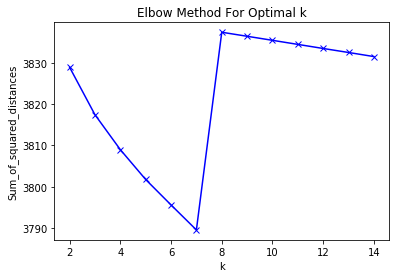

In [7]:
### cluster analysis
### vectorize the request text using tf-idf and remove stop words, hyperlinks and images for topic modeling

def preprocessor(s):
    # convert all letters to lower cases and remove non-letter characters
    new_s = s.lower()
    new_s = re.sub(r'\_',' ',new_s)
    new_s = re.sub(r'[^\w\s]',' ',new_s)
    new_s = re.sub(r'(http|com|www)', '', new_s)
    new_s = re.sub(r'(imgur|jpg|png|picture|pic|youtube)', '', new_s)
    return new_s

stopwords = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone",
             "able", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", 
             "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back",
             "be", "became", "because","become","becomes", "becoming", "been", "bee", "bees" "before", "beforehand", "behind", 
             "being", "below", "beside", "besides", "between", "beyond", "both", "bottom","but", "by", "call", "can", 
             "cannot", "cant", "co", "con", "could", "couldnt", "de", "describe", "detail", "do", "done", "don", "down", "due",
             "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "enough", "etc", "even", "ever", "every", 
             "everyone", "everything", "everywhere", "except", "es", "few", "fill", "find", "fire", "first", "for", "found", 
             "from", "front", "full", "further", "get", "got", "give", "going", "go", "had", "has", "hasnt", "have", "he", 
             "hence", "her", "here", "hers", "herself", "hey", "hi", "him", "himself", "his", "how", "however", "ie", "if", 
             "in", "inc", "indeed", "into", "is", "it", "its", "im", "ll", "till", "i", "itself", "just",  "keep", "ltd", "link",
             "last", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", 
             "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", 
             "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", 
             "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", 
             "per", "perhaps", "please", "put", "rather", "re", "really", "reddit", "request", "same", "see", "seem", 
             "seemed", "seeming", "seems","several", "she", "should", "show", "side", "since", "sincere", "so", "some",
             "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "than", "that", "the", 
             "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", 
             "thereupon", "these", "they", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", 
             "together", "too", "top", "toward", "towards", "un", "under", "until", "up", "upon", "us", "ve", "very", "via", 
             "was", "we", "well", "were", "what", "whatever", "when", "whenever", "where", "whereafter", "whereas", "whereby",
             "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom",
             "whose",  "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", 
             "yourselves"]

vectorizer = TfidfVectorizer(stop_words=stopwords, preprocessor = preprocessor)
X = vectorizer.fit_transform(df_train['request_text'])
sum_of_squared_dist = []
K = range(2,15)

for k in K:
    model = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    model.fit(X)
    sum_of_squared_dist.append(model.inertia_)

plt.plot(K, sum_of_squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



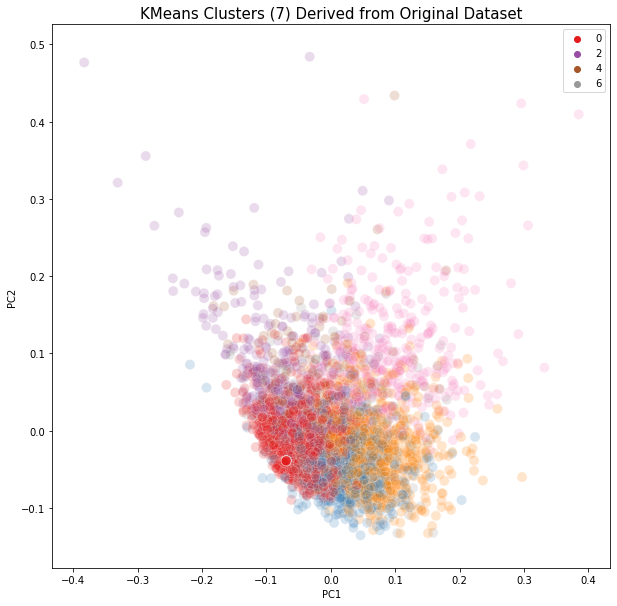

In [8]:
# use PCA to reduce dimensionality
# import sys
# !conda install --yes plotly
# ref: https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6
kmeans =KMeans(n_clusters = 7, init='k-means++', max_iter=100, n_init=1, random_state=0).fit(X)
labels = kmeans.labels_

pca = PCA().fit(X.toarray())
pca_2d = pca.transform(X.toarray())

plt.figure(figsize = (10,10))
sns.scatterplot(pca_2d[:,0], pca_2d[:,1], 
                hue=labels, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (7) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

We can see there are clear edges to separate four of the clusters but the remaining 3 are mixed together.
In addition, the elbow chart above shows large sum of squared distance for k from 2 to 14. The two observations signal the curse of dimensionality. Hence, we should apply PCA for feature reduction.

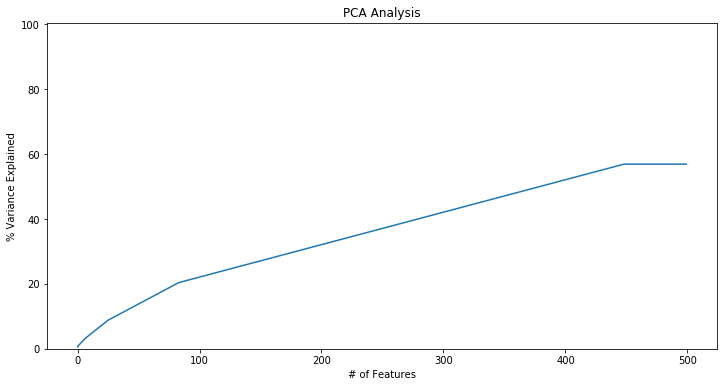

In [9]:
# feature reduction via PCA
pca = PCA(n_components=500)
pca.fit(X.toarray())
variance = pca.explained_variance_ratio_
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(np.cumsum(np.round(variance, 3)*100))

pca = PCA(n_components=450)
pca_scale = pca.fit_transform(X.toarray())
pca_df_scale = pd.DataFrame(pca_scale, columns=['pc' + str(i) for i in range(1,451)])

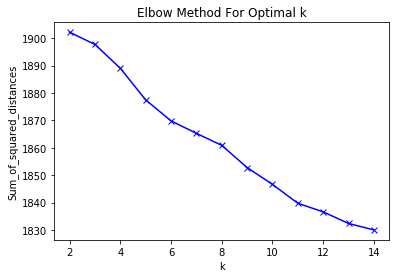

In [10]:
sum_of_squared_dist = []
K = range(2,15)

for k in K: 
    model = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    model.fit(pca_scale)
    sum_of_squared_dist.append(model.inertia_)

plt.plot(K, sum_of_squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

After applying feature reduction, we re-run the elbow methond and found that k=5 has the largest decrease in the sum of squared distance. We can now classify all requesters' posts into 5 groups.

## Topic Classification ##

We used a NMF model to bucket the posts into different topics.  Below you can see the top words in each topic.  The topic theme are as follows: <br> <br>
<b>Topic 1: Job, Help, Money (Between jobs or a lost job) <br>
Topic 2: Craving (Just really feel like eating pizza) <br>
Topic 3: Financial difficulty / Pay forward <br>
Topic 4: Students (Broke & Hungry Students) <br>
Topic 5: Financial difficulty / Reciprocity (Will have money soon to pay it back/Thursday and Friday paydays mentioned) <br> <br> </b>
One can also see that success rates vary by topic.  Topics 1, 3, and 5 which all mentioned financial difficulty were more successful than Topics 2 & 4 that mention cravings or being a hungry student.

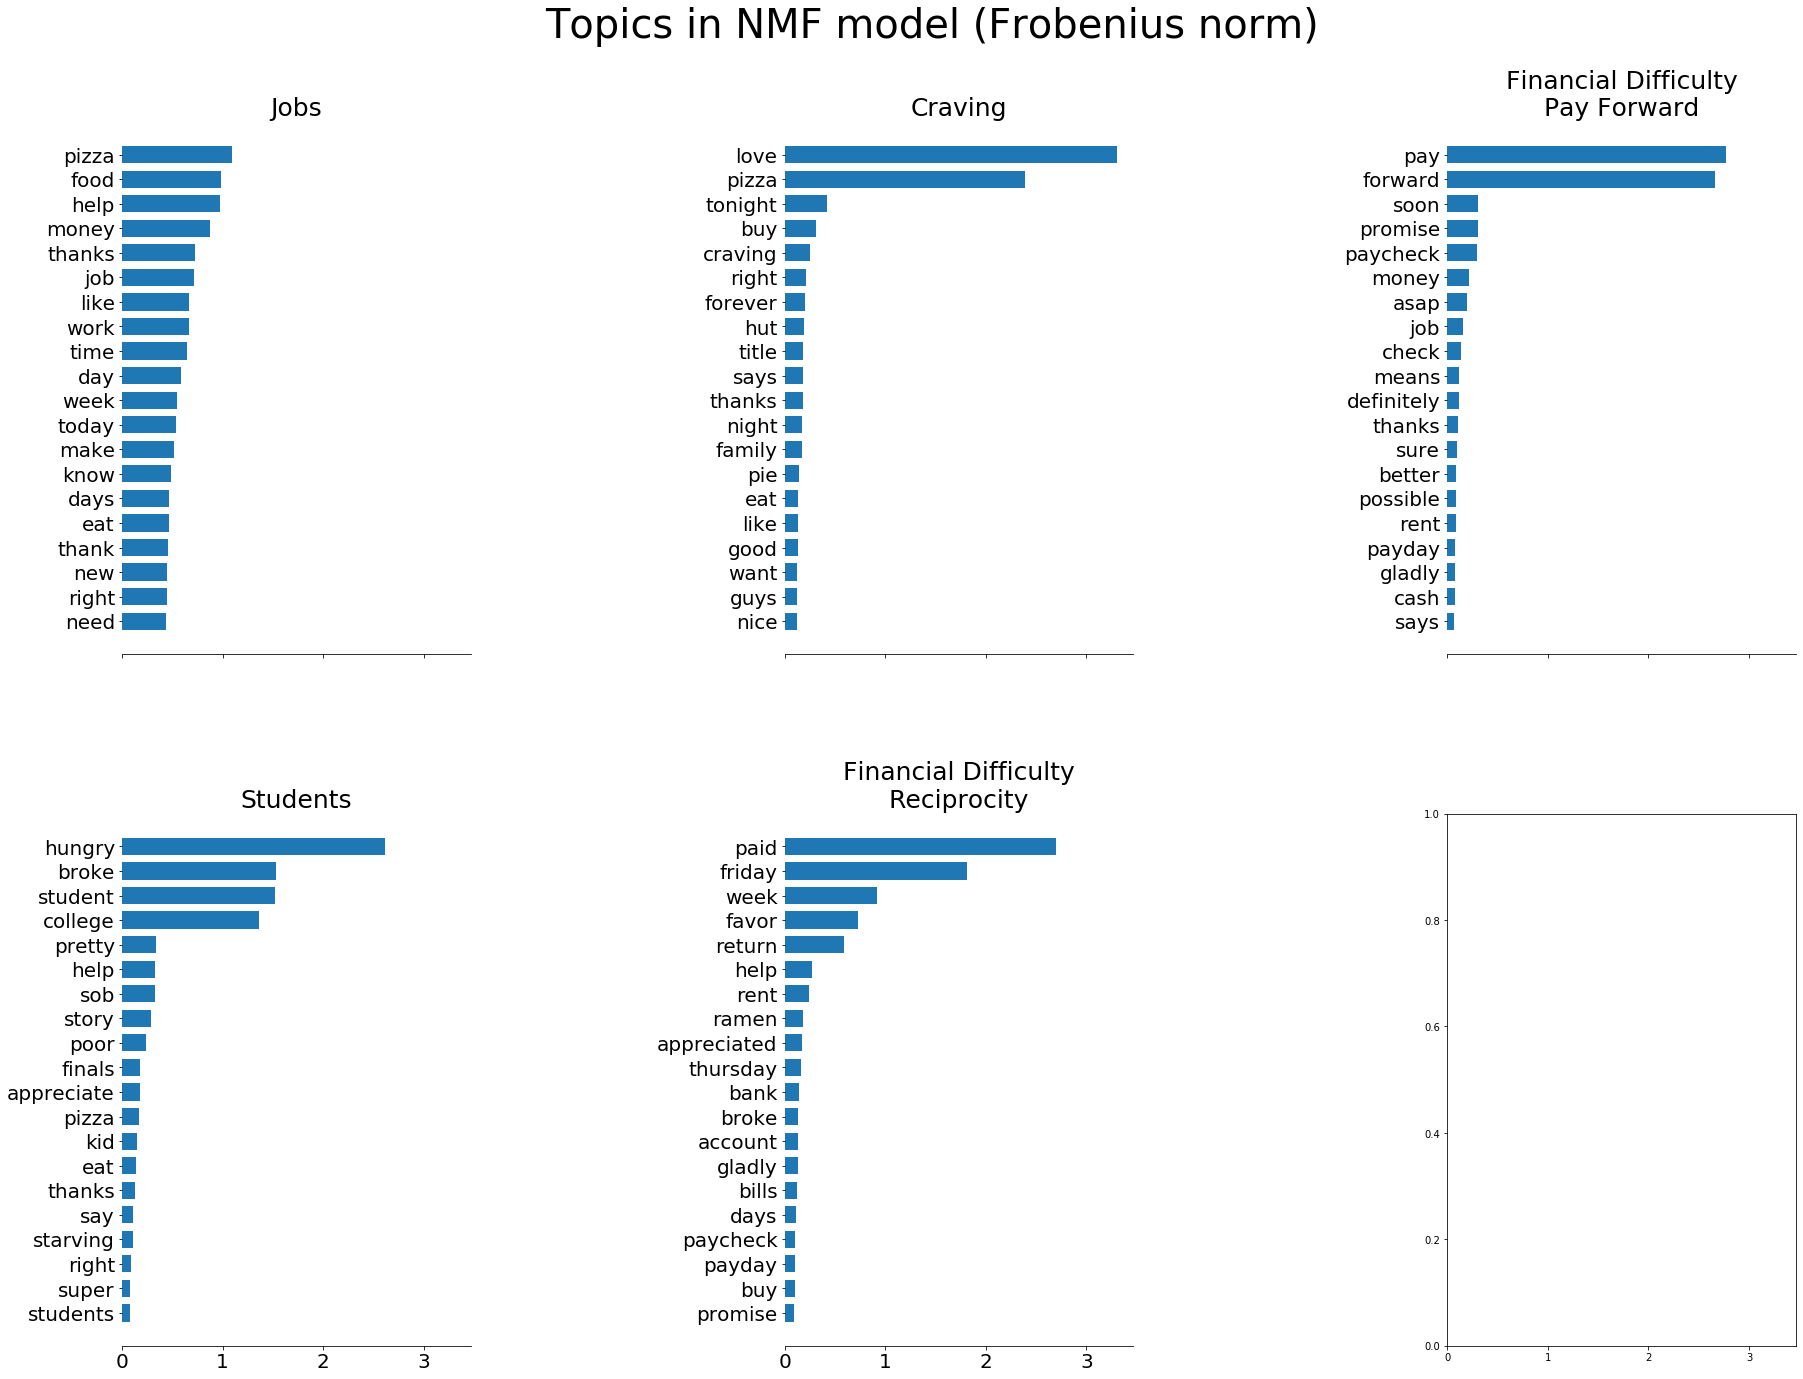

In [11]:
## Apply NMF method to identify the 5 topic groups and top 20 words in each topic

n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 20

# Fit the NMF model 1
nmf = NMF(n_components=n_components, random_state=0,
          alpha=.1, l1_ratio=.5).fit(X)
nmf_topic_values = nmf.transform(X)
tfidf_feature_names = vectorizer.get_feature_names()

def plot_top_words(model, feature_names, n_top_words, title, topic_names):
    fig, axes = plt.subplots(2, 3, figsize=(30, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(topic_names[topic_idx],
                     fontdict={'fontsize': 25})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

topic_names = ['Jobs', 'Craving', 'Financial Difficulty\nPay Forward', 'Students',
              'Financial Difficulty\nReciprocity']
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)', topic_names)

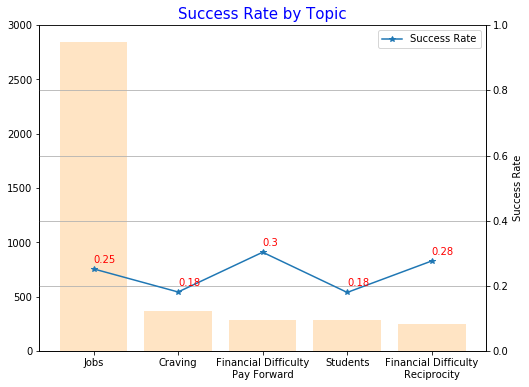

In [12]:
topic_feature_dict = []
for topic_idx, topic in enumerate(nmf.components_):
    top_features_ind = topic.argsort()[:-n_top_words*2 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    topic_feature_dict.append(top_features[:])    
    
word_count = np.zeros((df_train.shape[0],n_components))
for i in range(n_components):
    words_re = '|'.join(topic_feature_dict[i])
    words_re = "r'" + words_re + "'"
    for j, text in enumerate(df_train['request_title_text']):
        text = text.lower()
        text = re.sub(r'\_',' ',text)
        text = re.sub(r'[^\w\s]',' ',text)
        word_count[j, i] = pd.Series(text.split()).str.contains(words_re).sum()

# For each topic, count number of occurrences of the top 20 words in each post + title
word_count_df = pd.DataFrame(word_count, columns=list(['Topic1_count','Topic2_count', 'Topic3_count',
                                                       'Topic4_count', 'Topic5_count']))
df_train = pd.concat([df_train, word_count_df], axis=1)

# Use NMF model to assign topic to training posts
df_train['NMF_topic'] = nmf_topic_values.argmax(axis=1)
    
# Successful rate for each topic
labels = []
SR = []
total = []
for i in range(n_components):
    labels.append(topic_names[i])
    total.append(df_train[df_train['NMF_topic'] == i].shape[0])
    SR.append(float(df_train[(df_train['NMF_topic'] == i) & (df_train['requester_received_pizza'] == True)].shape[0])/
              df_train[df_train['NMF_topic'] == i].shape[0])

fig = plt.figure(figsize=(8,6))
plt.bar(range(n_components), total, color='bisque', label='Number of requests')
plt.ylim(0, 3000)
ax = plt.twinx()
ax.grid()

ax.plot(labels, SR, label='Success Rate', marker='*')
ax.set_ylim(0, 1)
ax.set_title('Success Rate by Topic', color='blue', size=15)
for i in range(n_components):
    ax.annotate(round(SR[i],2), xy=(i, SR[i]+0.02), color='red')

ax.set_ylabel('Success Rate')
ax.legend()

In [13]:
word_count = np.zeros((df_test.shape[0],n_components))
for i in range(n_components):
    words_re = '|'.join(topic_feature_dict[i])
    words_re = "r'" + words_re + "'"
    for j, text in enumerate(df_test['request_title_text']):
        text = text.lower()
        text = re.sub(r'\_',' ',text)
        text = re.sub(r'[^\w\s]',' ',text)
        word_count[j, i] = pd.Series(text.split()).str.contains(words_re).sum()

word_count_df_test = pd.DataFrame(word_count, columns=list(['Topic1_count','Topic2_count', 'Topic3_count',
                                                       'Topic4_count', 'Topic5_count']))
df_test = pd.concat([df_test, word_count_df_test], axis=1)

Xtest = vectorizer.transform(df_test['request_text_edit_aware'])

In [14]:
# # Requests include images
visual = re.compile(r'(imgur\.com|\.jpg|png|picture|pic|youtube)', re.IGNORECASE)
visual_count = df_train['request_text_edit_aware'].apply(lambda x: len(visual.findall(x)))
visual_count_test = df_test['request_text_edit_aware'].apply(lambda x: len(visual.findall(x)))
df_train['includes_visuals'] = np.where(visual_count > 0,1,0)
df_test['includes_visuals'] = np.where(visual_count_test > 0,1,0)

# # Requests include hyperlinks
hyperlink = re.compile(r'http[s]?://\S+|www\.', re.IGNORECASE)
hyperlink_count = df_train['request_text_edit_aware'].apply(lambda x: len(hyperlink.findall(x)))
hyperlink_count_test = df_test['request_text_edit_aware'].apply(lambda x: len(hyperlink.findall(x)))
df_train['includes_hyperlink'] = np.where(hyperlink_count > 0,1,0)
df_train['ones'] = np.ones(df_train.shape[0])
df_test['includes_hyperlink'] = np.where(hyperlink_count_test > 0,1,0)
df_test['ones'] = np.ones(df_test.shape[0])

## Sentiment Analysis ##

We used a SentimentIntensityAnalyzer to see if a post had a negative or positive sentiment.  Most posts were positive.  When breaking it down by suceess rate, one can see that posts resulting in pizza were slightly more positive.

In [15]:
# Sentiment analysis
# https://realpython.com/python-nltk-sentiment-analysis/
sia = SentimentIntensityAnalyzer()
req_polarity = [sia.polarity_scores(x) for x in df_train['request_text_edit_aware']]
sentiment_pos = [x['pos'] for x in req_polarity]
sentiment_neg = [x['neg'] for x in req_polarity]
sentiment_pos_neg = [(x['pos'], x['neg']) for x in req_polarity]
sentiment_bin = np.array([x[0]>x[1] for x in sentiment_pos_neg])
df_train['sentiment_bin'] = sentiment_bin.astype(int)

In [16]:
#replicate for test data
sia_test = SentimentIntensityAnalyzer()
req_polarity_test = [sia_test.polarity_scores(x) for x in df_test['request_text_edit_aware']]
sentiment_pos_test = [x['pos'] for x in req_polarity_test]
sentiment_neg_test = [x['neg'] for x in req_polarity_test]
sentiment_pos_neg_test = [(x['pos'], x['neg']) for x in req_polarity_test]
sentiment_bin_test = np.array([x[0]>x[1] for x in sentiment_pos_neg_test])
df_test['sentiment_bin'] = sentiment_bin_test.astype(int)

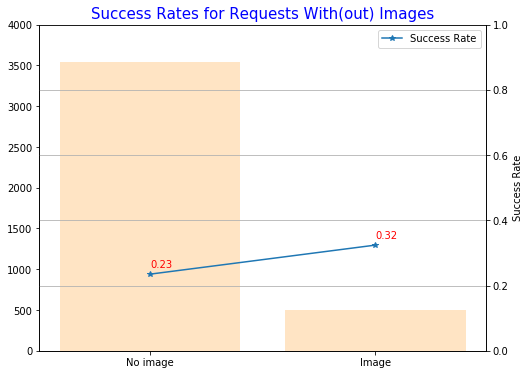

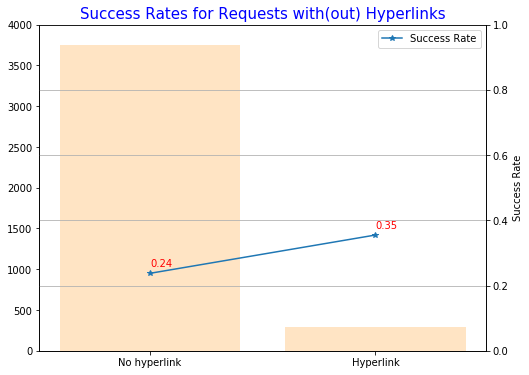

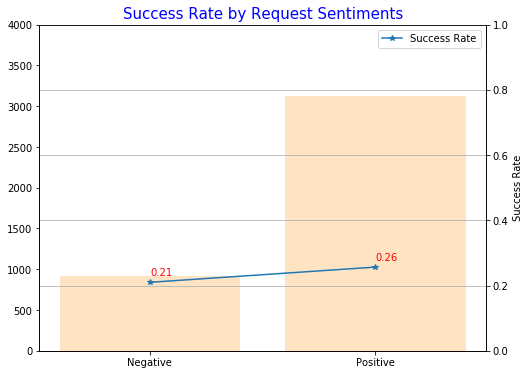

In [17]:
# Successful rate for each topic
visual_labels = ["No image", "Image"]
hyperlinks_labels = ["No hyperlink", "Hyperlink"]
sentiment_labels = ["Negative", "Positive"]

def binary_success_chart(param, labels, title):
    SR = []
    total = []
    for i in range(2):
        total.append(df_train[df_train[param] == i].shape[0])
        SR.append(float(df_train[(df_train[param] == i) & 
                                 (df_train['requester_received_pizza'] == True)].shape[0])/
                  df_train[df_train[param] == i].shape[0])

    fig = plt.figure(figsize=(8,6))
    plt.bar(range(2), total, color='bisque', label='Number of requests')
    plt.ylim(0, 4000)
    ax = plt.twinx()
    ax.grid()

    ax.plot(labels, SR, label='Success Rate', marker='*')
    ax.set_ylim(0, 1)
    ax.set_title(title, color='blue', size=15)
    for i in range(2):
        ax.annotate(round(SR[i],2), xy=(i, SR[i]+0.02), color='red')

    ax.set_ylabel('Success Rate')
    ax.legend()
    
binary_success_chart('includes_visuals', visual_labels, 'Success Rates for Requests With(out) Images')
binary_success_chart('includes_hyperlink', hyperlinks_labels, 'Success Rates for Requests with(out) Hyperlinks')
binary_success_chart('sentiment_bin', sentiment_labels, 'Success Rate by Request Sentiments')

In [18]:
# Normalize topic features
# convert from frequency to decile from 0 to 1
for i in range(n_components):
    df_train['Topic'+ str(i + 1) +'_dec'] = pd.qcut(df_train['Topic'+ str(i + 1) +'_count'].rank(method='first'), 
                                                    q = 10, labels = False)
for i in range(n_components):
    df_test['Topic'+ str(i + 1) +'_dec'] = pd.qcut(df_test['Topic'+ str(i + 1) +'_count'].rank(method='first'), 
                                                    q = 10, labels = False)

## <u>Train and Dev Data Split </u>

In [19]:
columns_for_modeling = ['requester_account_age_in_days_at_request', 
                        'requester_days_since_first_post_on_raop_at_request', 
                        'requester_number_of_comments_in_raop_at_request', 
                        'requester_number_of_posts_on_raop_at_request', 
                        'requester_upvotes_minus_downvotes_at_request', 
                        'Length_of_Post',
                        'RAOP_member_at_time_of_request', 
                        'zero_to_three', 
                        'four_to_seven', 
                        'eight_to_eleven', 
                        'twelve_to_fifteen', 
                        'sixteen_to_nineteen', 
                        'twenty_to_twentythree',
                        'beg_month_of_request',
                        'includes_visuals',
                        'includes_hyperlink',
                        'Topic1_dec','Topic2_dec', 'Topic3_dec',
                        'Topic4_dec', 'Topic5_dec',
                        'sentiment_bin']

train_labels = np.where(df_train['requester_received_pizza'] == True,1,0)

In [20]:
# split into 80% training data and 20% dev data
train_data_split, dev_data, train_labels_split, dev_labels = train_test_split(
    df_train[columns_for_modeling], train_labels, test_size=0.2, random_state=42)

Xtrain, Xdev, train_labels_split, dev_labels = train_test_split(
    X, train_labels, test_size=0.2, random_state=42)

In [21]:
# split into 80% training data and 20% dev data
train_data_split2, dev_data2, train_labels_split2, dev_labels2 = train_test_split(
    df_train, train_labels, test_size=0.2, random_state=42)

## <u>Modeling</u>

In [22]:
def combine_model_preds(text_model_preds, num_model_preds):

    model_probas = []
    for i in text_model_preds:
        if i[0] == np.max(i):
            model_probas.append(1-i[0])
        else:
            model_probas.append(i[1])

    positive_preds_49 = []
    for i in model_probas:
        if i >= .499:
            positive_preds_49.append(1)
        else:
            positive_preds_49.append(0)

    text_num_mod_positive_preds = []

    for i in range(0, len(num_model_preds)):
        if num_model_preds[i] == 1:
            text_num_mod_positive_preds.append(1)
        else:
            if positive_preds_49[i] == 1:
                text_num_mod_positive_preds.append(1)
            else:
                text_num_mod_positive_preds.append(0)
    
    return text_num_mod_positive_preds



In [23]:
class_weights = {0: .33, 1:1}
LR_model = LogisticRegression(C=0.1, solver="liblinear", multi_class="auto", class_weight=class_weights)
LR_model.fit(Xtrain, train_labels_split)
LR_model_preds = LR_model.predict(Xdev)
LR_model_pred_prb = LR_model.predict_proba(Xdev)
print("dev data accuracy:", accuracy_score(dev_labels, LR_model_preds))

dev data accuracy: 0.6621287128712872


## K-Nearest Neighbors

Running a KNN with more features results in an accuracy scores that was 10% higher.

In [24]:
#transform the training and development data to matrices of word unigram feature vectors.
vectorizer = CountVectorizer()
vectors_train = vectorizer.fit_transform(train_data_split2['request_text_edit_aware'])
vectors_dev = vectorizer.transform(dev_data2['request_text_edit_aware'])

print("---k-Nearest Neighbor Models (Plain Vanilla)---")
#Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. For each model, show the k value and f1 score.
knn_pred = []
for k in (range(1,11,1)):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(vectors_train, train_labels_split2)
    predictions_k = neigh.predict(vectors_dev) #run model on development data
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    print("k: ",k,"f-1 score: ",metrics.f1_score(dev_labels2, predictions_k, average='weighted'))
    if k == 10:
        knn_pred = predictions_k
    else:
        continue
    
    
# KNN model
print("")
print("---k-Nearest Neighbor Model (Enhanced Features)---")
KNN_params = {'n_neighbors':range(1,11)}
clf_KNN = KNeighborsClassifier()
clf = GridSearchCV(clf_KNN, KNN_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
clf_KNN = KNeighborsClassifier(n_neighbors=10)
clf_KNN.fit(train_data_split, train_labels_split)
predictions_k = clf_KNN.predict(dev_data) #run model on development data
print("dev data accuracy:", accuracy_score(dev_labels, predictions_k))

print("Vanilla KNN Model with 10 neighbors, Accuracy: 0.634003899267747")
print("Improvement:",accuracy_score(dev_labels, predictions_k) - 0.634003899267747)    
    

---k-Nearest Neighbor Models (Plain Vanilla)---
k:  1 f-1 score:  0.6740430609120551
k:  2 f-1 score:  0.6392409480773659
k:  3 f-1 score:  0.6467317099647923
k:  4 f-1 score:  0.6376242128990692
k:  5 f-1 score:  0.6480304132902308
k:  6 f-1 score:  0.6361520249446148
k:  7 f-1 score:  0.6420600553054568
k:  8 f-1 score:  0.634003899267747
k:  9 f-1 score:  0.6382994773250171
k:  10 f-1 score:  0.634003899267747

---k-Nearest Neighbor Model (Enhanced Features)---
Best parameters: {'n_neighbors': 10}
Best score: 0.7484529702970297
dev data accuracy: 0.7363861386138614
Vanilla KNN Model with 10 neighbors, Accuracy: 0.634003899267747
Improvement: 0.10238223934611435


KNN + TF-IDF: ROC AUC=0.557
KNN - Vanilla: ROC AUC=0.553


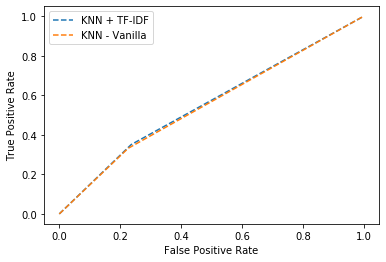

In [25]:
# Combine prediction results from the KNN model and from
# the logistic regression model generated based on TF-IDF vectorizer
KNN_auc = roc_auc_score(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_k))
KNN_van_auc = roc_auc_score(dev_labels, combine_model_preds(LR_model_pred_prb, knn_pred))
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('KNN - Vanilla: ROC AUC=%.3f' % (KNN_van_auc))
# calculate roc curves
KNN_fpr, KNN_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_k))
KNN_van_fpr, KNN_van_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, knn_pred))
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(KNN_van_fpr, KNN_van_tpr, linestyle='--', label='KNN - Vanilla')
#use c = '0.85' to make grayscale

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Naive Bayes

In [26]:
print("---Multinomial Naive Bayes Models (Plain Vanilla)---")
#Produce several Naive Bayes models by varying smoothing (alpha)

nb_pred = []
for a in (1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0):
    clf_NB = MultinomialNB(alpha = a)
    clf_NB.fit(vectors_train, train_labels_split2)
    predictions_NB = clf_NB.predict(vectors_dev)
    print("alpha: ",a,"f-1 score: ",metrics.f1_score(dev_labels2, predictions_NB, average='weighted'))
    if a == 0.1:
        nb_pred = predictions_NB
    else:
        continue

---Multinomial Naive Bayes Models (Plain Vanilla)---
alpha:  1e-10 f-1 score:  0.6570933879339601
alpha:  0.0001 f-1 score:  0.6553677492744764
alpha:  0.001 f-1 score:  0.6553677492744764
alpha:  0.01 f-1 score:  0.6657677129627825
alpha:  0.1 f-1 score:  0.6721411998923325
alpha:  0.5 f-1 score:  0.6667176772192821
alpha:  1.0 f-1 score:  0.6369485908678771
alpha:  2.0 f-1 score:  0.6295768170548306
alpha:  10.0 f-1 score:  0.6272954218498773


KNN + TF-IDF: ROC AUC=0.557
Naive Bayes: ROC AUC=0.544


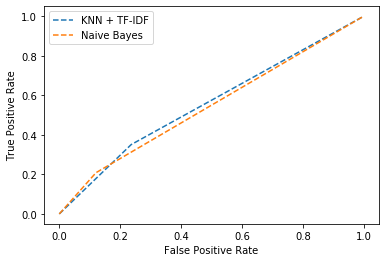

In [27]:
KNN_auc = roc_auc_score(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_k))
NB_auc = roc_auc_score(dev_labels, nb_pred)
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('Naive Bayes: ROC AUC=%.3f' % (NB_auc))
# calculate roc curves
KNN_fpr, KNN_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_k))
NB_fpr, NB_tpr, _ = roc_curve(dev_labels, nb_pred)
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(NB_fpr, NB_tpr, linestyle='--', label='Naive Bayes')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Logistic Regression

Running a Logistic Regresssion with more features results in an accuracy scores that was almost 9% higher.

In [28]:
print("---Logistic Regression Models (Plain Vanilla)---")   
#Produce several Logistic Regression models by varying L2 regularization strength (C)    

lr_pred_van = []
for reg in (1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0):
    clf_LR = LogisticRegression(C=reg, solver="liblinear", multi_class="auto")
    #Inverse of regularization strength; must be a positive float. 
    #Like in support vector machines, smaller values specify stronger regularization.
    clf_LR.fit(vectors_train, train_labels_split2)
    predictions_LR = clf_LR.predict(vectors_dev)
    print("C: ",reg,"f-1 score: ",metrics.f1_score(dev_labels2, predictions_LR, average='weighted'))
    if reg == 0.1:
        lr_pred_van = predictions_LR
    else:
        continue

---Logistic Regression Models (Plain Vanilla)---
C:  1e-10 f-1 score:  0.6279007082202882
C:  0.0001 f-1 score:  0.6279007082202882
C:  0.001 f-1 score:  0.6279007082202882
C:  0.01 f-1 score:  0.6430325469642579
C:  0.1 f-1 score:  0.664003871237197


C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:  0.5 f-1 score:  0.6600329849241512
C:  1.0 f-1 score:  0.6559738367809995
C:  2.0 f-1 score:  0.6436084208702925
C:  10.0 f-1 score:  0.6491093869732878


KNN + TF-IDF: ROC AUC=0.557
Naive Bayes: ROC AUC=0.544
Logistic - Vanilla: ROC AUC=0.528


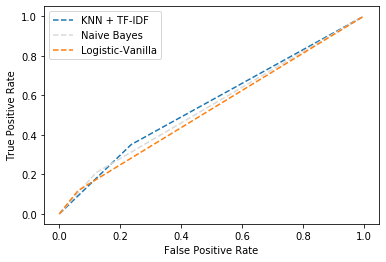

In [29]:
# Combine prediction results from the logistic regresiion model generated using all numerical features
# and from the logistic regression model generated based on TF-IDF vectorizer
LG_van_auc = roc_auc_score(dev_labels, lr_pred_van)
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('Naive Bayes: ROC AUC=%.3f' % (NB_auc))
print('Logistic - Vanilla: ROC AUC=%.3f' % (LG_van_auc))
# calculate roc curves
LG_van_fpr, LG_van_tpr, _ = roc_curve(dev_labels, lr_pred_van)
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(NB_fpr, NB_tpr, linestyle='--', label='Naive Bayes',c='0.85')
plt.plot(LG_van_fpr, LG_van_tpr, linestyle='--', label='Logistic-Vanilla')
#use c = '0.85' to make grayscale

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Make Logistic Regression Better...

We experimented with different text processing and different word gram sizes.

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packag

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ambe Chen\Anaconda3\lib\site-packag

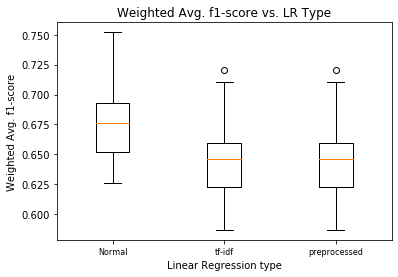

In [30]:
def better_preprocessor(data):
    """ Pre-process text data by going lowercase, removing html tags,
    removing numbers and removing punctuation"""
    process_data = []
    for msg in data:
        # go lowercase
        lower_msg = msg.lower()
        # remove HTML tags
        no_html = re.sub('<.*?>', '', lower_msg)   
        # remove punctuation
        no_punc = re.sub(r'[^\w\s]', '', no_html) 
        # remove numbers
        no_nums = re.sub(r'\b(\d+)\b','#',no_punc)
        # truncate words
        trunc_msg = ""
        for word in no_nums.split():
            trunc_msg += word[:6]+ " "
        process_data.append(trunc_msg)
    return process_data

# lists of our f1 scores
f1_normal = []
f1_tf = []
f1_tfpre = []

# Do this 5 times to not overfit to dev data
n = 25
for rep in range(n):
    train_data_exp = None
    with open('../Raw Data/train.json', 'r') as f:
        data = f.read()
        train_data_exp = json.loads(data)

    # split into dev and train data
    dev_ind = random.sample(range(0, 4039), 404)
    dev_ind_srt = sorted(dev_ind, reverse=True)
    dev_data_exp = []
    for ind in dev_ind_srt:
        dev_data_exp.append(train_data_exp.pop(ind))

    ## Transform the training data into a matrix of word unigram feature vectors.
    # get a nice list of the request text
    text_train_data = []
    for i in range(len(train_data_exp)):
        text_train_data.append(train_data_exp[i]['request_text_edit_aware'])
    text_dev_data = []
    for i in range(len(dev_data_exp)):
        text_dev_data.append(dev_data_exp[i]['request_text_edit_aware'])

    train_labels_exp = []
    for i in range(len(train_data_exp)):
        train_labels_exp.append(train_data_exp[i]['requester_received_pizza'])
    dev_labels_exp = []
    for i in range(len(dev_data_exp)):
        dev_labels_exp.append(dev_data_exp[i]['requester_received_pizza'])

    # create a vectorizer
    vectorizer = CountVectorizer()
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(text_train_data)
    X_dev = vectorizer.transform(text_dev_data)

    ## What is the size of the vocabulary? 

    # Check the size of the vocabulary
    #print('There are', np.shape(X_train)[1], 'words in the vocabulary.')

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_normal.append(f1_score)

    # create a vectorizer
    vectorizer = TfidfVectorizer()
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(text_train_data)
    X_dev = vectorizer.transform(text_dev_data)

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_tf.append(f1_score)

    # run the preprocessor
    process_train_data = better_preprocessor(text_train_data)
    process_dev_data = better_preprocessor(text_dev_data)

    # create a vectorizer
    vectorizer = TfidfVectorizer(stop_words=stopwords)
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(process_train_data)
    X_dev = vectorizer.transform(process_dev_data)

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_tfpre.append(f1_score)

# Plot results    
fig, ax = plt.subplots()
plt.boxplot([f1_normal,f1_tf,f1_tfpre])
plt.xlabel("Linear Regression type")
plt.ylabel("Weighted Avg. f1-score")
plt.title('Weighted Avg. f1-score vs. LR Type')
x_tick_labels = ['Normal','tf-idf','preprocessed']
ax.set_xticklabels(x_tick_labels, fontsize=8)
plt.show()

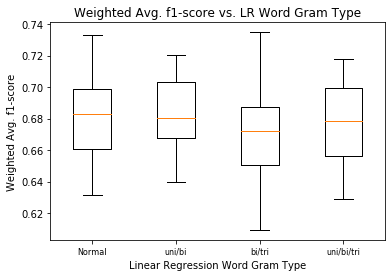

In [31]:
f1_normal = []
f1_unibi = []
f1_bitri = []
f1_unibitri = []

n = 25
for i in range(n):
    train_data_exp = None
    with open('../Raw Data/train.json', 'r') as f:
        data = f.read()
        train_data_exp = json.loads(data)

    # split into dev and train data
    dev_ind = random.sample(range(0, 4039), 404)
    dev_ind_srt = sorted(dev_ind, reverse=True)
    dev_data_exp = []
    for ind in dev_ind_srt:
        dev_data_exp.append(train_data_exp.pop(ind))

    ## Transform the training data into a matrix of word unigram feature vectors.
    # get a nice list of the request text
    text_train_data = []
    for i in range(len(train_data_exp)):
        text_train_data.append(train_data_exp[i]['request_text_edit_aware'])
    text_dev_data = []
    for i in range(len(dev_data_exp)):
        text_dev_data.append(dev_data_exp[i]['request_text_edit_aware'])

    train_labels_exp = []
    for i in range(len(train_data_exp)):
        train_labels_exp.append(train_data_exp[i]['requester_received_pizza'])
    dev_labels_exp = []
    for i in range(len(dev_data_exp)):
        dev_labels_exp.append(dev_data_exp[i]['requester_received_pizza'])

    # create a vectorizer
    vectorizer = CountVectorizer()
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(text_train_data)
    X_dev = vectorizer.transform(text_dev_data)

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_normal.append(f1_score)

    # create a vectorizer with unigrams and bigrams
    vectorizer = CountVectorizer(ngram_range=(1, 2))
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(text_train_data)
    X_dev = vectorizer.transform(text_dev_data)

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_unibi.append(f1_score)

    # create a vectorizer with bigrams and trigrams
    vectorizer = CountVectorizer(ngram_range=(2, 3))
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(text_train_data)
    X_dev = vectorizer.transform(text_dev_data)

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_bitri.append(f1_score)

    # create a vectorizer with unigrams, bigrams, and trigrams
    vectorizer = CountVectorizer(ngram_range=(1, 3))
    # fill the vectorizer matrix up from our training data
    X_train = vectorizer.fit_transform(text_train_data)
    X_dev = vectorizer.transform(text_dev_data)

    # Produce Logistic regression classifier with multinomial input
    clf_lr = LogisticRegression(solver="liblinear", multi_class="auto", C=0.15)
    # train classifier on training data
    clf_lr.fit(X_train, train_labels_exp)
    # fit classifier to dev data and print report
    predicted_lr = clf_lr.predict(X_dev)
    # get the f1 score and print it. append it to the list of f1 scores
    f1_score = metrics.f1_score(dev_labels_exp, predicted_lr, average="weighted")
    f1_unibitri.append(f1_score)
    
# Plot results    
fig, ax = plt.subplots()
plt.boxplot([f1_normal,f1_unibi,f1_bitri,f1_unibitri])
plt.xlabel("Linear Regression Word Gram Type")
plt.ylabel("Weighted Avg. f1-score")
plt.title('Weighted Avg. f1-score vs. LR Word Gram Type')
x_tick_labels = ['Normal','uni/bi','bi/tri','uni/bi/tri']
ax.set_xticklabels(x_tick_labels, fontsize=8)
plt.show()

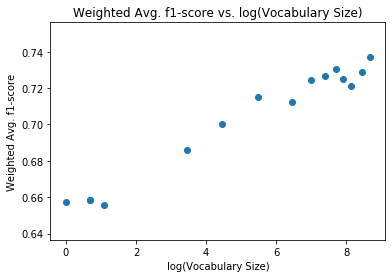

In [32]:
Cs = [1.0e-10, 0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
# set up arrays to hold f1 scores and vocabulary sizes for plotting later
f1s = []
vocab_size = []
## Produce a Logistic Regression model (with no preprocessing of text). 
# Transform the training and development data to matrices of word unigram feature vectors.
# create a vectorizer for training and dev data 
vectorizer_un = CountVectorizer()
# fill the vectorizer matrix up from our training data
X_train = vectorizer_un.fit_transform(text_train_data)
# vectorize the dev data based on the training data
X_dev   = vectorizer_un.transform(text_dev_data)
    
for c in Cs:
    ## Produce a Logistic Regression model using the L1 regularization strength.
    # Produce Logistic regression classifier with multinomial input, L1 penalty, and relaxed convergence criteria
    clf_l1 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
    # train classifier on training data
    clf_l1.fit(X_train, train_labels_exp)

    ## Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
    # get unique array of nonzero coefficients
    nonzero = np.unique(np.where(clf_l1.coef_ != 0)[1])
    # check if we have any words and give error if our vocabulary is empty
    if len(nonzero) == 0:
        continue
    else:
        # add vocabulary size to list for plotting later
        vocab_size.append(len(nonzero))
        # set up a new vocabulary from the words matching the coefficients with nonzero weights
        new_vocab = []
        for word in nonzero:
            new_vocab.append(vectorizer_un.get_feature_names()[word])
        # create a vectorizer for training and dev data with new vocabulary
        vectorizer_slim = CountVectorizer(vocabulary=new_vocab)
        # fill the vectorizer matrix up from our training data
        X_train_slim = vectorizer_slim.fit_transform(text_train_data)
        # vectorize the dev data based on the training data
        X_dev_slim   = vectorizer_slim.transform(text_dev_data)

        ## Produce a new Logistic Regression model using the reduced vocabulary and L2 regularization strength of 0.5.
        clf_l2 = LogisticRegression(C=0.15, solver="liblinear", multi_class="auto", penalty="l2")
        # train classifier on training data
        clf_l2.fit(X_train_slim, train_labels_exp)

        ## Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
        # print the L1 regularization strength and vocabulary size
        #print('-'*50,'\nL1 Regularization strength =',c)
        #print('Vocabulary size =',len(nonzero))
        # Evaluate f1 score of new model
        # fit classifier to dev data and print report
        predicted = clf_l2.predict(X_dev_slim)
        # get the f1 score and print it. append it to the list of f1 scores
        f1_score = metrics.f1_score(dev_labels_exp, predicted, average="weighted")
        # add this f1 score to the list to plot later.
        f1s.append(f1_score)


## Show a plot of f1 score vs. log vocabulary size. Each point corresponds to a specific L1 regularization strength 
## used to reduce the vocabulary.
# plot f1 score vs 
plt.scatter(np.log(vocab_size),f1s)
plt.xlabel("log(Vocabulary Size)")
plt.ylabel("Weighted Avg. f1-score")
plt.title('Weighted Avg. f1-score vs. log(Vocabulary Size)')
plt.show()



In [33]:
## Transform the training data into a matrix of word unigram feature vectors.
    
# create a vectorizer with unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))
# fill the vectorizer matrix up from our training data
X_train = vectorizer.fit_transform(df_train['request_text_edit_aware'])
# Check the size of the vocabulary
#print('There are', np.shape(X_train)[1], 'words in the vocabulary.')

# Produce Logistic regression classifier with multinomial input
clf_l1 = LogisticRegression(C=0.2, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
# train classifier on training data
clf_l1.fit(X_train, train_labels)

## Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
# get unique array of nonzero coefficients
nonzero = np.unique(np.where(clf_l1.coef_ != 0)[1])
# check if we have any words and give error if our vocabulary is empty
if len(nonzero) == 0:
    print('-'*50,'\nL1 Regularization strength =',c)
    print('Error: Empty vocabulary')
else:
    # add vocabulary size to list for plotting later
    vocab_size.append(len(nonzero))
    # set up a new vocabulary from the words matching the coefficients with nonzero weights
    new_vocab = []
    for word in nonzero:
        new_vocab.append(vectorizer.get_feature_names()[word])
    # create a vectorizer for training and dev data with new vocabulary
    vectorizer_slim = CountVectorizer(vocabulary=new_vocab)
    # fill the vectorizer matrix up from our training data
    X_train_slim = vectorizer_slim.fit_transform(df_train['request_text_edit_aware'])
    # vectorize the dev data based on the training data
    X_test_slim = vectorizer_slim.transform(df_test['request_text_edit_aware'])
    
## Produce a new Logistic Regression model using the reduced vocabulary and L2 regularization strength of 0.5.
clf_l2 = LogisticRegression(C=0.2, solver="liblinear", multi_class="auto", penalty="l2")
# train classifier on training data
clf_l2.fit(X_train_slim, train_labels)

## Evaluate 
# fit classifier to test data and print report
predicted = clf_l2.predict(X_test_slim)

In [34]:
# Minimalist model based on TF-IDF of request texts
# 'TF-IDF + Decision Tree Positives Model'
# Running a simple 1-ngram word analyzer TF-IDF vectorizer
# Combine a logistic regression model based on text features and a decision tree model based on numerical features
# First, use the TF-IDF vectorizer to fit/transform training and dev data
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
Tfidf_vectorizer.fit(df_train['request_text_edit_aware'])
Tfidf_vectorized_train_data = Tfidf_vectorizer.transform(df_train['request_text_edit_aware'])

Xtrain_3, Xdev_3, train_labels_split_3, dev_labels_3 = train_test_split(
    Tfidf_vectorized_train_data, train_labels, test_size=0.2, random_state=42)

# Generate Logistic Regression model using TF-IDF vectorized data, make predictions, and report F1 score
class_weights = {0: .33, 1:1}
LR_model_min = LogisticRegression(C=.05, solver="liblinear", multi_class="auto", class_weight=class_weights)
LR_model_min.fit(Xtrain, train_labels_split)
LR_model_preds_min = LR_model_min.predict(Xdev)
LR_model_pred_prb_min = LR_model_min.predict_proba(Xdev)
columns_for_DTmodel = ['requester_account_age_in_days_at_request', 
                        'requester_days_since_first_post_on_raop_at_request', 
                        'requester_number_of_comments_in_raop_at_request', 
                        'requester_number_of_posts_on_raop_at_request', 
                        'requester_upvotes_minus_downvotes_at_request', 
                        'Length_of_Post', # From here down are engineered features, not natural ones... must be matched in the test data
                        'RAOP_member_at_time_of_request', 
                        'zero_to_three', 
                        'four_to_seven', 
                        'eight_to_eleven', 
                        'twelve_to_fifteen', 
                        'sixteen_to_nineteen', 
                        'twenty_to_twentythree',
                        'beg_month_of_request',
                        'sentiment_bin']

train_data_DT, dev_data_DT, train_labels_DT, dev_labels_DT = train_test_split(
    df_train[columns_for_DTmodel], train_labels, test_size=0.2, random_state=42)

# Generate a decision tree model for the numerical features
decision_tree = DecisionTreeClassifier(max_depth = 20, criterion='entropy', min_samples_leaf=5)
decision_tree.fit(train_data_DT, train_labels_DT)

DT_preds = decision_tree.predict(dev_data_DT)

KNN + TF-IDF: ROC AUC=0.557
Naive Bayes: ROC AUC=0.544
Logistic - Vanilla: ROC AUC=0.528
DT + TF-IDF - Minimal: ROC AUC=0.561


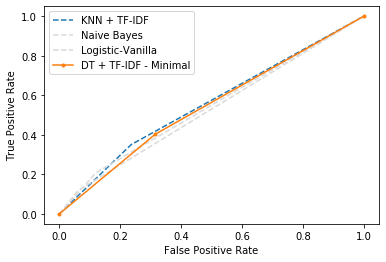

In [35]:
# Combine prediction results from the decision tree model generated using all numerical features
# and from the logistic regression model generated based on TF-IDF vectorizer
mod3_auc = roc_auc_score(dev_labels_DT, combine_model_preds(LR_model_pred_prb, DT_preds))
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('Naive Bayes: ROC AUC=%.3f' % (NB_auc))
print('Logistic - Vanilla: ROC AUC=%.3f' % (LG_van_auc))
print('DT + TF-IDF - Minimal: ROC AUC=%.3f' % (mod3_auc))
# calculate roc curves
mod3_fpr, mod3_tpr, _ = roc_curve(dev_labels_DT, combine_model_preds(LR_model_pred_prb_min, DT_preds))
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(NB_fpr, NB_tpr, linestyle='--', label='Naive Bayes',c='0.85') #gray out NB
plt.plot(LG_van_fpr, LG_van_tpr, linestyle='--', label='Logistic-Vanilla', c='0.85')
plt.plot(mod3_fpr, mod3_tpr, marker='.', label='DT + TF-IDF - Minimal')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Find an optimimal logistic regression model on all numerical features

In [36]:
print("")
print("---Logistic Regression Model (Enhanced Features)---")    
LogReg_params = {'C':[1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
clf = GridSearchCV(LogisticRegression(solver="liblinear", multi_class="auto"), 
                   LogReg_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

C = clf.best_params_['C']
clf_LR = LogisticRegression(C=C, solver="liblinear", multi_class="auto")
clf_LR.fit(train_data_split, train_labels_split)
predictions_LR = clf_LR.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_LR))
print("Vanilla Logistic Regression Model with C = 0.1, Accuracy: 0.664003871237197")
print("Improvement:",accuracy_score(dev_labels, predictions_LR) - 0.664003871237197)


---Logistic Regression Model (Enhanced Features)---
Best parameters: {'C': 0.1}
Best score: 0.7626856435643564
dev data accuracy: 0.7524752475247525
Vanilla Logistic Regression Model with C = 0.1, Accuracy: 0.664003871237197
Improvement: 0.08847137628755553


KNN + TF-IDF: ROC AUC=0.557
Naive Bayes: ROC AUC=0.544
Logistic - Vanilla: ROC AUC=0.528
DT + TF-IDF - Minimal: ROC AUC=0.561
Logistic + TF-IDF: ROC AUC=0.567


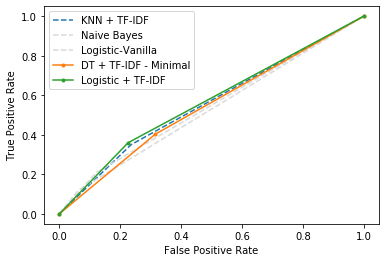

In [37]:
# Combine prediction results from the logistic regression model generated using all numerical features
# and from the logistic regression model generated based on TF-IDF vectorizer
LR_auc = roc_auc_score(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_LR))
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('Naive Bayes: ROC AUC=%.3f' % (NB_auc))
print('Logistic - Vanilla: ROC AUC=%.3f' % (LG_van_auc))
print('DT + TF-IDF - Minimal: ROC AUC=%.3f' % (mod3_auc))
print('Logistic + TF-IDF: ROC AUC=%.3f' % (LR_auc))

# calculate roc curves
LR_fpr, LR_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_LR))
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(NB_fpr, NB_tpr, linestyle='--', label='Naive Bayes',c='0.85') #gray out NB
plt.plot(LG_van_fpr, LG_van_tpr, linestyle='--', label='Logistic-Vanilla', c='0.85') #gray out log reg vanilla model
plt.plot(mod3_fpr, mod3_tpr, marker='.', label='DT + TF-IDF - Minimal')
plt.plot(LR_fpr, LR_tpr, marker='.', label='Logistic + TF-IDF')
#use c = '0.85' to make grayscale

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Random Forest

In [38]:
# Random Forest model
RF_params = {'criterion':('gini', 'entropy'), 'n_estimators':[100, 300, 500, 700, 1000, 2000], 'max_features':('sqrt','log2')}
clf_RF = RandomForestClassifier()
clf = GridSearchCV(clf_RF, RF_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
criterion_rf = clf.best_params_['criterion']
n_estimators_rf = clf.best_params_['n_estimators']
max_features_rf = clf.best_params_['max_features']
clf_RF = RandomForestClassifier(n_estimators=n_estimators_rf, criterion=criterion_rf, max_features=max_features_rf)
clf_RF.fit(train_data_split, train_labels_split)
predictions_RF = clf_RF.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_RF))

Best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}
Best score: 0.7586633663366337
dev data accuracy: 0.7425742574257426


KNN + TF-IDF: ROC AUC=0.557
Naive Bayes: ROC AUC=0.544
Logistic - Vanilla: ROC AUC=0.528
DT + TF-IDF - Minimal: ROC AUC=0.561
Logistic + TF-IDF: ROC AUC=0.567
Random Forest + TF-IDF: ROC AUC=0.575


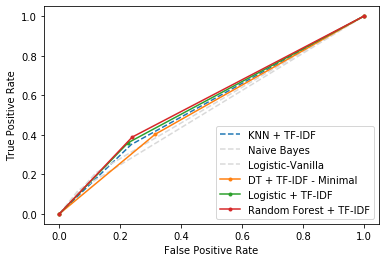

In [39]:
# Combine predictions from the random forest model and the TF-IDF logistics regression model
RF_auc = roc_auc_score(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_RF))
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('Naive Bayes: ROC AUC=%.3f' % (NB_auc))
print('Logistic - Vanilla: ROC AUC=%.3f' % (LG_van_auc))
print('DT + TF-IDF - Minimal: ROC AUC=%.3f' % (mod3_auc))
print('Logistic + TF-IDF: ROC AUC=%.3f' % (LR_auc))
print('Random Forest + TF-IDF: ROC AUC=%.3f' % (RF_auc))
# calculate roc curves
RF_fpr, RF_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_RF))
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(NB_fpr, NB_tpr, linestyle='--', label='Naive Bayes',c='0.85') #gray out NB
plt.plot(LG_van_fpr, LG_van_tpr, linestyle='--', label='Logistic-Vanilla', c='0.85') #gray out vanilla log reg model
plt.plot(mod3_fpr, mod3_tpr, marker='.', label='DT + TF-IDF - Minimal')
plt.plot(LR_fpr, LR_tpr, marker='.', label='Logistic + TF-IDF')
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest + TF-IDF')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Predict on test data and submit to Kaggle

In [41]:
LR_model_test = LogisticRegression(C=0.1, solver="liblinear", multi_class="auto", class_weight='balanced')
LR_model_test.fit(X, train_labels)
Text_model_preds_test = LR_model_test.predict(Xtest)
Text_model_pred_prb_test = LR_model_test.predict_proba(Xtest)

df_prediction = df_test[['request_id']]
df_prediction['requester_received_pizza_RF'] = combine_model_preds(Text_model_pred_prb_test, 
                                                          clf_RF.predict(df_test[columns_for_modeling]))
df_test['requester_received_pizza'] = df_prediction['requester_received_pizza_RF']
df_test[['request_id', 'requester_received_pizza']].to_csv('kaggle_submission_RF.csv')

df_prediction['requester_received_pizza_LR_AC'] = combine_model_preds(Text_model_pred_prb_test, 
                                                          clf_LR.predict(df_test[columns_for_modeling]))
df_test['requester_received_pizza'] = df_prediction['requester_received_pizza_LR_AC']
df_test[['request_id', 'requester_received_pizza']].to_csv('kaggle_submission_LR_AC.csv')

df_prediction['requester_received_pizza_KNN'] = combine_model_preds(Text_model_pred_prb_test, 
                                                          clf_KNN.predict(df_test[columns_for_modeling]))
df_test['requester_received_pizza'] = df_prediction['requester_received_pizza_KNN']
df_test[['request_id', 'requester_received_pizza']].to_csv('kaggle_submission_KNN.csv')

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [42]:
# Re-train the Decision tree + TF-IDF model on full training set
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1)) #Removed stopwords, because it doesn't seem to improve the model...
Tfidf_vectorizer.fit(df_train['request_text_edit_aware'])
Tfidf_vectorized_train_data = Tfidf_vectorizer.transform(df_train['request_text_edit_aware'])
Tfidf_vectorized_test_data = Tfidf_vectorizer.transform(df_test['request_text_edit_aware'])

# Generate Logistic Regression model using TF-IDF vectorized data, make predictions
class_weights = {0: .33, 1:1}
LR_model_min = LogisticRegression(C=.05, solver="liblinear", multi_class="auto", class_weight=class_weights)
LR_model_min.fit(Tfidf_vectorized_train_data, train_labels)
LR_model_preds_min = LR_model_min.predict(Tfidf_vectorized_test_data)
LR_model_pred_prb_min = LR_model_min.predict_proba(Tfidf_vectorized_test_data)

decision_tree.fit(df_train[columns_for_DTmodel], train_labels)
DT_preds = decision_tree.predict(df_test[columns_for_DTmodel])

df_prediction['requester_received_pizza_LR_min'] = combine_model_preds(LR_model_pred_prb_min, 
                                                          decision_tree.predict(df_test[columns_for_DTmodel]))
df_test['requester_received_pizza'] = df_prediction['requester_received_pizza_LR_min']
df_test[['request_id', 'requester_received_pizza']].to_csv('kaggle_submission_LR_min.csv')

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Baseline & Modeling Results

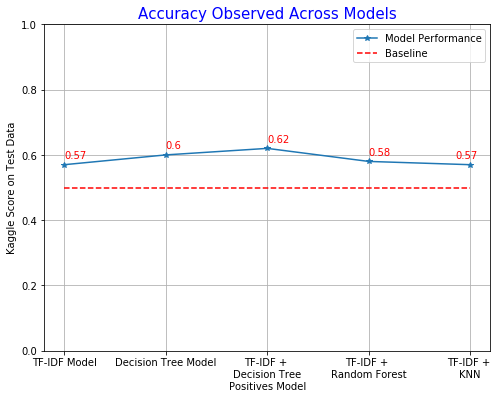

In [45]:
kaggle_submission_DT_results = .57
kaggle_submission_LR_results = .60
kaggle_submission_DTLR_results = .62
kaggle_submission_RFLR_results = .58
kaggle_submission_KNNLR_results = .57

data = [kaggle_submission_DT_results, kaggle_submission_LR_results, kaggle_submission_DTLR_results,
       kaggle_submission_RFLR_results, kaggle_submission_KNNLR_results]
labels = ['TF-IDF Model', 'Decision Tree Model', 'TF-IDF + \nDecision Tree\nPositives Model',
          'TF-IDF + \nRandom Forest', 'TF-IDF + \nKNN']

baseline = []
for p in data:
    baseline.append(.5)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.grid() 
ax.plot(labels, data, label='Model Performance', marker='*')
ax.plot(baseline, label='Baseline', color='red', linestyle='--')
ax.set_ylim(0, 1)
ax.set_title('Accuracy Observed Across Models', color='blue', size=15)
ax.annotate(data[0], xy=(0, .59), color='red')
ax.annotate(data[1], xy=(1, .62), color='red')
ax.annotate(data[2], xy=(2, .64), color='red')
ax.annotate(data[3], xy=(3, .60), color='red')
ax.annotate(data[4], xy=(3.85, .59), color='red')
ax.set_ylabel('Kaggle Score on Test Data')
ax.legend()

KNN + TF-IDF: ROC AUC=0.557
Naive Bayes: ROC AUC=0.544
Logistic - Vanilla: ROC AUC=0.528
DT + TF-IDF - Minimal: ROC AUC=0.561
Logistic + TF-IDF: ROC AUC=0.567
Random Forest + TF-IDF: ROC AUC=0.575


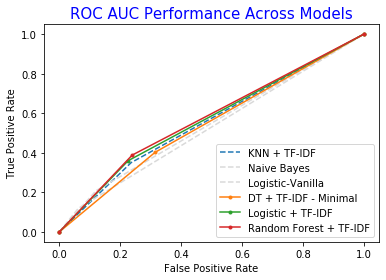

In [48]:
# summarize scores
print('KNN + TF-IDF: ROC AUC=%.3f' % (KNN_auc))
print('Naive Bayes: ROC AUC=%.3f' % (NB_auc))
print('Logistic - Vanilla: ROC AUC=%.3f' % (LG_van_auc))
print('DT + TF-IDF - Minimal: ROC AUC=%.3f' % (mod3_auc))
print('Logistic + TF-IDF: ROC AUC=%.3f' % (LR_auc))
print('Random Forest + TF-IDF: ROC AUC=%.3f' % (RF_auc))
# calculate roc curves
RF_fpr, RF_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, predictions_RF))
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN + TF-IDF')
plt.plot(NB_fpr, NB_tpr, linestyle='--', label='Naive Bayes',c='0.85') #gray out NB
plt.plot(LG_van_fpr, LG_van_tpr, linestyle='--', label='Logistic-Vanilla', c='0.85') #gray out vanilla log reg model
plt.plot(mod3_fpr, mod3_tpr, marker='.', label='DT + TF-IDF - Minimal')
plt.plot(LR_fpr, LR_tpr, marker='.', label='Logistic + TF-IDF')
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest + TF-IDF')
# axis labels
plt.title('ROC AUC Performance Across Models', color='blue', size=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()